In [1]:
pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install  -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [8]:
#!/usr/bin/env python
# coding: utf-8
from typing import Any
from torchmetrics import AveragePrecision

import pandas as pd
import csv
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from glob import glob
import torch.nn.functional as F
import torch.nn as nn 
import torch
from torch.autograd import Variable
import pytorch_lightning as pl

from tqdm import tqdm

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.cuda.device_count()

1

In [11]:
torch.cuda.current_device()

0

In [12]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [16]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device is : {device}')

filename = glob('convert_fov_to_tile_index/*.csv')
print('done')
print(filename)
df = pd.concat((pd.read_csv(file) for file in filename), ignore_index=True)

df['index_of_center_tile'] = df['index_of_center_tile'].replace(np.NaN, 63.0)
# df = df.dropna()
df = df.drop(columns=['qx', 'qy', 'qz', 'qw'])
df.set_index('timestamp', inplace=True)
df['index_of_center_tile'] = df['index_of_center_tile'].astype(int)
sector = df.groupby('index_of_center_tile')

target_arr = np.zeros((len(df), 64))
for i in range(len(df)):
    target_arr[i][df['index_of_center_tile'].iloc[i]] = 1
train_data = df[df.columns[0:6]].to_numpy()

# Load dataset
x_train, x_test,y_train, y_test = train_test_split(train_data, target_arr, test_size=0.4, random_state=0)
print(x_train.shape)
print(y_train.shape)

X_train = x_train.reshape(93607,1, 6)




The device is : cuda
done
['convert_fov_to_tile_index\\1.csv', 'convert_fov_to_tile_index\\10.csv', 'convert_fov_to_tile_index\\11.csv', 'convert_fov_to_tile_index\\12.csv', 'convert_fov_to_tile_index\\13.csv', 'convert_fov_to_tile_index\\2.csv', 'convert_fov_to_tile_index\\3.csv', 'convert_fov_to_tile_index\\4.csv', 'convert_fov_to_tile_index\\5.csv', 'convert_fov_to_tile_index\\6.csv', 'convert_fov_to_tile_index\\7.csv', 'convert_fov_to_tile_index\\8.csv', 'convert_fov_to_tile_index\\9.csv']
(93607, 6)
(93607, 64)


In [17]:
train_data

array([[ 1.02079846e-03,  8.41746000e-02,  7.30089843e-02,
        -5.02744570e-01, -3.17905633e+00,  7.83623925e-02],
       [ 1.04075799e-03,  8.41478685e-02,  7.29465978e-02,
        -5.05531901e-01, -3.16897762e+00,  7.47179899e-02],
       [ 1.06071752e-03,  8.41211369e-02,  7.28842113e-02,
        -5.08318562e-01, -3.15889873e+00,  7.10741137e-02],
       ...,
       [ 1.63970828e+00,  1.32819660e-01,  2.14718207e-01,
         2.73136840e+01, -1.24493186e+01,  6.57684534e+01],
       [ 1.63786221e+00,  1.32701497e-01,  2.15582184e-01,
         2.72541801e+01, -1.25427695e+01,  6.52985684e+01],
       [ 1.63601613e+00,  1.32583335e-01,  2.16446161e-01,
         2.71938713e+01, -1.26357407e+01,  6.48284135e+01]])

In [18]:
class FastTensorDataLoader:
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.lstm = nn.LSTM(6,50) # making lstm layer with 6 input features and 50 outputs 
        # the arch. exactly same as given in the file !!
        self.lin1 = nn.Linear(50,64)
        self.lin2 = nn.Linear(64,128)
        self.drop = nn.Dropout(0.2)
        self.lin3 = nn.Linear(128,64)
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        
        ## this is confidnet part !!!
        # which will return the uncertainity !!
        self.uncertainty1 = nn.Linear(128, 96) # output shape of lin2 is given here 
        self.uncertainty2 = nn.Linear(96,96) # because pred from lin2 is passed in uncertainty 1 to cal. uncertainty
        self.uncertainty3 = nn.Linear(96,96)
        self.uncertainty4 = nn.Linear(96,64)
        self.uncertainty5 = nn.Linear(64, 1)

    def forward(self,x):        
        x,_ = self.lstm(x)
        x = self.relu(self.lin1(x))
        x = self.drop(self.lin2(x))
        uncertainty = F.relu(self.uncertainty1(x))
        uncertainty = F.relu(self.uncertainty2(uncertainty))# 5 layers of uncertainty !
        uncertainty = F.relu(self.uncertainty3(uncertainty))
        uncertainty = F.relu(self.uncertainty4(uncertainty))
        uncertainty = F.relu(self.uncertainty5(uncertainty))       # the last layer dooes not need relu
        outputs = self.softmax(self.lin3(x))
        #print (outputs)
        #print (uncertainty)
        return outputs,uncertainty 
   
    def get_features(self):
        return nn.Sequential(
            self.lstm,
            self.relu,
            self.lin1,
            self.lin2,
            self.drop,
            self.lin3,
            self.softmax
                )


In [19]:

# converting arrays to tensors 
x_train = Variable(torch.from_numpy(x_train)) #test convert to array
y_train = Variable(torch.from_numpy(y_train))


x_test = Variable(torch.from_numpy(x_test))
y_test = Variable(torch.from_numpy(y_test))

# model,optim,loss fn
LSTM_model = Net()
if torch.cuda.is_available():
    LSTM_model.to(device)
print(LSTM_model)
train_batches = FastTensorDataLoader(x_train, y_train, batch_size=64, shuffle=False) 
test_batches = FastTensorDataLoader(x_test, y_test,batch_size=64, shuffle=False)

criterion = nn.CrossEntropyLoss() # change criteria to BCELoss then train 
optimizer = torch.optim.Adam(LSTM_model.parameters(),lr=0.001)


Net(
  (lstm): LSTM(6, 50)
  (lin1): Linear(in_features=50, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=128, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (lin3): Linear(in_features=128, out_features=64, bias=True)
  (softmax): Softmax(dim=None)
  (relu): ReLU()
  (uncertainty1): Linear(in_features=128, out_features=96, bias=True)
  (uncertainty2): Linear(in_features=96, out_features=96, bias=True)
  (uncertainty3): Linear(in_features=96, out_features=96, bias=True)
  (uncertainty4): Linear(in_features=96, out_features=64, bias=True)
  (uncertainty5): Linear(in_features=64, out_features=1, bias=True)
)


In [48]:
### starting to train !!

accuracy = []
losses = []
epoch = 500
val_losses = []
val_accs = []
uncertainties = []
val_uncertainties = []

# train loop starts !

for i in range(epoch):
    correct=0
    
    for x_batch,y_batch in tqdm(train_batches):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        optimizer.zero_grad()
        outputs,uncertainty = LSTM_model(x_batch)    
        
        uncertainties.append(uncertainty.cpu().detach().numpy())

        loss = criterion(outputs, y_batch)    
        loss.backward()    
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
        loss.item()
        correct += (outputs == y_batch).float().sum()
    acc = correct / (len(train_batches)*1000)
    accuracy.append(acc)
    uncertainty= torch.squeeze(uncertainty)
    
    with torch.no_grad():
        val_corr = 0
    
        for x_batch_val,y_batch_val in test_batches:
            x_batch_val = x_batch_val.to(device).float()
            y_batch_val = y_batch_val.to(device).float()
            
            val_out,val_unc = LSTM_model(x_batch_val)
            val_loss = criterion(val_out, y_batch_val)
            val_losses.append(val_loss)
            val_corr += (val_out == y_batch_val).float().sum()
            val_uncertainties.append(val_unc.cpu().detach().numpy())
            
        val_acc = val_corr/(len(test_batches)*1000)
        val_accs.append(val_acc)
        
    if i%100:
        print(f'Epoch: {i}, loss : {0.11 * torch.min(loss)}, accuracy: {0.2 * torch.max(acc)}, Confidence Score : {torch.max(uncertainty)}')
        #print(f'Epoch: {i}')

  0%|                                                                                         | 0/1463 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_3448\1962535064.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = self.softmax(self.lin3(x))
100%|█████████████████████████████████████████████████████████████████████████████| 1463/1463 [00:05<00:00, 292.43it/s]


Epoch: 1, loss : 0.3926489055156708, accuracy: 0.8098013997077942, Confidence Score : 0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1463/1463 [00:05<00:00, 290.73it/s]


Epoch: 2, loss : 0.3898768723011017, accuracy: 0.8097607493400574, Confidence Score : 0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1463/1463 [00:05<00:00, 290.17it/s]


Epoch: 3, loss : 0.38987866044044495, accuracy: 0.8097119331359863, Confidence Score : 0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1463/1463 [00:05<00:00, 288.51it/s]


KeyboardInterrupt: 

In [26]:
### copy of starting to train !!

accuracy = []
losses = []
epoch = 20
val_losses = []
val_accs = []
uncertainties = []
val_uncertainties = []
total =[]


# train loop starts !

for i in range(epoch):
    correct=0
    
    for x_batch,y_batch in tqdm(train_batches):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        optimizer.zero_grad()
        outputs, uncertainty = LSTM_model(x_batch)    
        
        

        loss = criterion(outputs, y_batch)    
        loss.backward()    
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
        loss.item()
        correct += (outputs == y_batch).float().sum()
        total += y_batch.size(0)

    acc = 100*correct / total
    accuracy.append(acc)
    
    
        
    if i%5:
        print(f'Epoch: {i}, loss : {loss.item()}, accuracy: {acc}, uncertainty : {uncertainty}')

  0%|                                                                                         | 0/1463 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_3448\1962535064.py:75: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = self.softmax(self.lin3(x))
  0%|                                                                                         | 0/1463 [00:00<?, ?it/s]


TypeError: 'int' object is not iterable

In [ ]:
accuracy = []
losses = []
epoch = 20
val_losses = []
val_accs = []
uncertainties = []
val_uncertainties = []

# train loop starts !

for i in range(epoch):
    for x_batch,y_batch in tqdm(train_batches):
        correct=0
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        optimizer.zero_grad()
        outputs,uncertainty = LSTM_model(x_batch)

        uncertainties.append(uncertainty.cpu().detach().numpy())

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
        loss.item()
        correct += (outputs == y_batch).float().sum()
    acc = correct / len(y_batch)
    accuracy.append(acc)

    with torch.no_grad():

        for x_batch_val,y_batch_val in test_batches:
            val_corr = 0
            x_batch_val = x_batch_val.to(device).float()
            y_batch_val = y_batch_val.to(device).float()

            val_out,val_unc = LSTM_model(x_batch_val)
            val_loss = criterion(val_out, y_batch_val)
            val_losses.append(val_loss)
            val_corr += (val_out == y_batch_val).float().sum()
            val_uncertainties.append(val_unc.cpu().detach().numpy())

        val_acc = val_corr/len(y_batch_val)
        val_accs.append(val_acc)

    if i%5:
        print(f'Epoch: {i}, loss : {loss}, accuracy: {acc}, uncertainty : {torch.mean(uncertainty)}')

In [31]:
torch.save(LSTM_model,'lstm_model.pth')


### plotting results :)

In [32]:


plt.plot(np.array(accuracy),color='red',linestyle='dashed',marker='o')
plt.plot(np.array(val_accs),color='green',linestyle='dashed',marker='o')
plt.ylim(0,1)


plt.title('Accuracy and val Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['LSTM Acc', 'LSTM Val Acc'], loc='lower right')
plt.show()


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

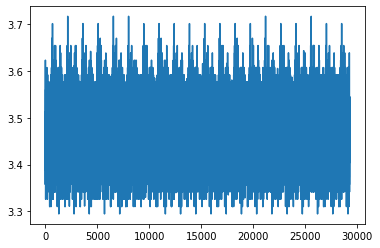

In [33]:

plt.plot(losses)
plt.plot(val_losses)
plt.ylim(0,1)


plt.title('Loss and val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['LSTM Loss', 'LSTM Val Loss' ], loc='upper right')

plt.show()
